# A Gentle Introduction to State Space Models in Python with `statsmodels`

Basic workflow:
1. Specify the model using math and wrangle it into the State Space form
2. Translate the state space form into `statsmodels` base `MLEModel` class
	1. Slot in required parameters and specify required matrices	
	2. Abstract away the messy estimation behind `.fit()`
3. Use the parameters to do something useful - predict, forecast, etc and inspect the results

## Notation

Notation among state space models is not entirely consistent, better to understand the meaning (or as code)

The generic form of a state space model from [statsmodels implementation docs](https://www.statsmodels.org/stable/statespace.html):

$$
\begin{aligned}
y_t &= Z_t\alpha_t + d_t + \epsilon_t, \quad \epsilon_t \sim N(0, H_t)\\
\alpha_{t+1} &= T_t\alpha_t + c_t + R_t\eta_t, \quad \eta_t \sim N(0, Q_t)
\end{aligned}
$$

Where:

| math | statsmodels parameter |
| --- | --- |
| $Z_t$ | `design` matrix|
| $d_t$ | `obs_intercept` |
| $H_t$ | `obs_cov` |
| $T_t$ | `transition` |
| $c_t$ | `state_intercept` |
| $R_t$ | `selection` matrix|
| $Q_t$ | `state_cov` |

Let's create one from scratch using the `sm.tsa.statespace.MLEModel` base class. 

In [1]:
%matplotlib inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

## Simple Linear Regression as a State Space Model

For our data, we'll simply use data from 10 home sales in my area from the past year, where we'll seek to understand the relationship between `sqFootage` of a home and its `salesPrice`. 

Text(0, 0.5, "Sale Price ($100K's)")

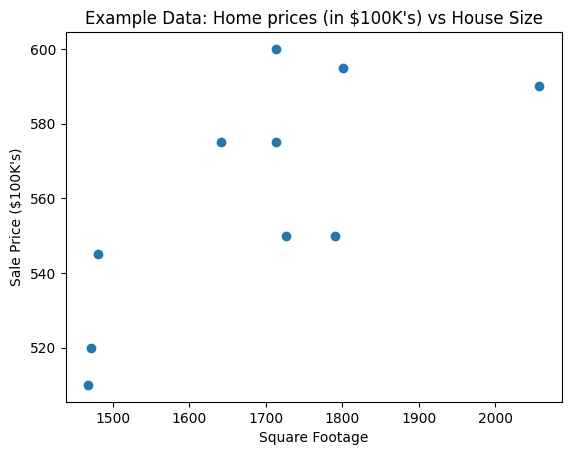

In [2]:
# Data
salesPrice = [590, 575, 550, 520, 545, 
              575, 550, 510, 595, 600]
sqFootage = [2057, 1713, 1791, 1472, 1481, 
             1642, 1727, 1468, 1801, 1713]

# As expected, larger the home the higher the sale price
plt.scatter(sqFootage, salesPrice)
plt.title("Example Data: Home prices (in $100K's) vs House Size")
plt.xlabel("Square Footage")
plt.ylabel("Sale Price ($100K's)")

A classic linear regression form of this model would look like:

$$
\begin{aligned}
\text{salesPrice} &= \beta(\text{sqFootage}) + \epsilon\\
\rightarrow y &= X\beta + \epsilon, \quad \epsilon \sim N(0, \sigma^2)\\
\end{aligned}
$$

Let's take a look at the OLS estimate of the $\beta$ coefficient (which in this case is an estimate of the sale price per square foot of a home).

In [3]:
res = sm.OLS(sqFootage, salesPrice).fit()
res.summary()

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1628.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):                    1.76e-11
Time:                        16:28:26   Log-Likelihood:                         -62.530
No. Observations:                  10   AIC:                                      127.1
Df Residuals:                       9   BIC:                                      127.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.0097      0.075     40.348      0.000       2.841       3.178
==============================================================================
Omnibus:                        3.729   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                1.591
Skew:                           0.976   Prob(JB):                        0.451
Kurtosis:                       3.063   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So an estimate $300 price per square foot from OLS. 

Since Linear Regression can be considered a special case of the state space model, we can state a simple linear regression in state space form as follows:

$$
\begin{aligned}
y_t &= X_t\beta_t + \epsilon_t, \quad \epsilon_t \sim N(0, H_t)\\
\beta_t &= I\beta_{t-1} + 0
\end{aligned}
$$


In order to convert this equation into code, we can take advantage of the `sm.tsa.statespace.MLEModel` base class and our problem becomes one in which we need to 'fill in the blank' and slot stuff in their proper location in the class. 

### The `MLEModel`

In [4]:
"""
Linear Regression in State Space Form
"""
class LinearRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t):
        # reshape x_t into a column vector (nobs, 1)
        exog = np.array(x_t).reshape(-1, 1) 

        # Model order - only 1 state
        k_states = 1

        # Initialize the statespace
        super().__init__(endog=y_t, 
                         exog=exog,
                         k_states=k_states,
                         initialization='diffuse'
                         )

        # Initialize the state space matrices
        # Design matrix is shaped k_endog x k_states x nobs
        # or 1 x 1 x nobs
        self.ssm['design'] = exog.T[np.newaxis, :]
        self.ssm['transition'] = np.eye(k_states)

    @property
    def param_names(self):
        return ['H']

    @property
    def start_params(self):
        """Define starting values for the parameters"""
        return np.array([3])

    def transform_params(self, unconstrained:np.array)->np.array:
        """
        Called during .fit(), we'll take unconstrained parameters
        and constrain them to be positive
        """
        return unconstrained**2

    def untransform_params(self, constrained:np.array)->np.array:
        """
        Need to untransform all the parameters you transformed
        in the `transform_params` function
        """
        return constrained**0.5

    def update(self, params, **kwargs):
        """
        Slot parameters to their location in the 
        state space matrices
        """
        params = super().update(params, **kwargs)

        # Observation covariance
        self.ssm['obs_cov', 0, 0] = params[0]

Fitting the model becomes as simple as `.fit()`:

In [5]:
mod = LinearRegression(salesPrice, sqFootage)
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91464D+02    |proj g|=  3.33407D+02

At iterate    5    f=  2.98573D+01    |proj g|=  9.11073D+00

At iterate   10    f=  8.01122D+00    |proj g|=  4.41206D-01

At iterate   15    f=  5.69009D+00    |proj g|=  1.55666D-02

At iterate   20    f=  5.63153D+00    |proj g|=  2.13332D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1     20     21      1     0     0   2.133D-06   5.632D+00
  F =   5.6315317788939527     

CONVERG

 This problem is unconstrained.


Recall that $X$ was our `design` matrix and the $\beta$ coefficients were our hidden states, we can recover our estimates of the hidden $\beta$ values using the `.smoothed_state` parameter in the fitted model:

smoothed state : [[0.33043213 0.33043213 0.33043213 0.33043213 0.33043213 0.33043213
  0.33043213 0.33043213 0.33043213 0.33043213]]


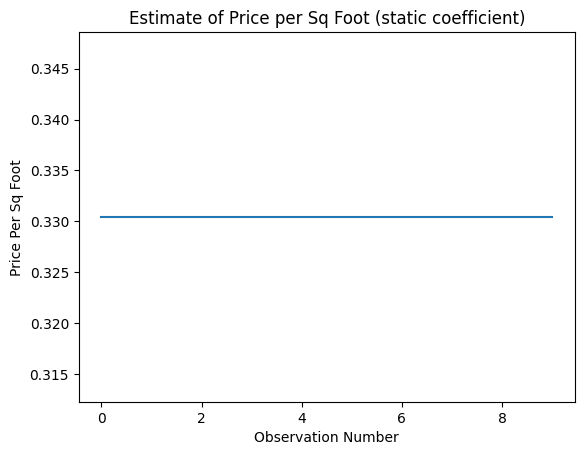

In [6]:
# See the estimated dynamic coefficients
print("smoothed state :", res.smoothed_state)
plt.plot(np.arange(res.smoothed_state.shape[1]), res.smoothed_state[0]);
plt.ylabel("Price Per Sq Foot")
plt.xlabel("Observation Number")
plt.title("Estimate of Price per Sq Foot (static coefficient)")
plt.show()

And as expected we see a constant $\beta$ throughout, but it is different than the estimate of $\beta$ from OLS.

## Make it time-varying

In which we modify the state space model to become a dynamic linear model - a model in which the regression coefficients can vary over time.

Let's say that the regression coefficients evolve like a random walk. In the state space form, what this means is that we'll add a new parameter to the state equation:

$$
\begin{aligned}
y_t &= X_t\beta_t + \epsilon_t, \quad \epsilon_t \sim N(0, H_t)\\
\beta_t &= I\beta_{t-1} + I\eta_t, \quad \eta_t \sim N(0, Q_t)
\end{aligned}
$$

This is also simple to achieve in our model - we simply need to add a new parameter `eta` and slot it into the `state_cov` matrix.

In [7]:
"""
Dynamic Linear Regression in State Space Form
"""
class DynamicLinearRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t):
        # reshape x_t into a column vector (nobs, 1)
        exog = np.array(x_t).reshape(-1, 1) 
        # Model order
        k_states = 1  # Still only one hidden state/beta coefficient

        # Initialize the statespace
        super().__init__(endog=y_t, 
                         exog=exog,
                         k_states=k_states,
                         initialization='diffuse'
                         )

        # Initialize the state space matrices
        # Design matrix is shaped k_endog x k_states x nobs
        # or 1 x 1 x nobs
        self.ssm['design'] = exog.T[np.newaxis, :]
        self.ssm['transition'] = np.eye(k_states)
        self.ssm['selection'] = np.eye(k_states)  # The new selection matrix is just the identity

    @property
    def param_names(self):
        return ['H', 'Q'] # new parameter

    @property
    def start_params(self):
        """Define starting values for the parameters"""
        return np.array([3, 1])

    def transform_params(self, unconstrained:np.array)->np.array:
        """
        Called during .fit(), we'll take unconstrained parameters
        and constrain them to be positive
        """
        return unconstrained**2

    def untransform_params(self, constrained:np.array)->np.array:
        """
        Need to untransform all the parameters you transformed
        in the `transform_params` function
        """
        return constrained**0.5

    def update(self, params, **kwargs):
        """
        Slot parameters to their location in the 
        state space matrices
        """
        params = super().update(params, **kwargs)

        # Observation covariance
        self.ssm['obs_cov', 0, 0] = params[0]
        self.ssm['state_cov', 0, 0] = params[1]

In [8]:
# fit the model again
mod2 = DynamicLinearRegression(salesPrice, sqFootage)
res2 = mod2.fit()

print(res2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34455D+00    |proj g|=  8.99154D-01
  ys=-8.715E+00  -gs= 8.348E-01 BFGS update SKIPPED

At iterate    5    f=  5.65413D+00    |proj g|=  2.74220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     35      2     1     0   4.689D-04   5.654D+00
  F =   5.6541313405607729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                              Statespace Model Results                          

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


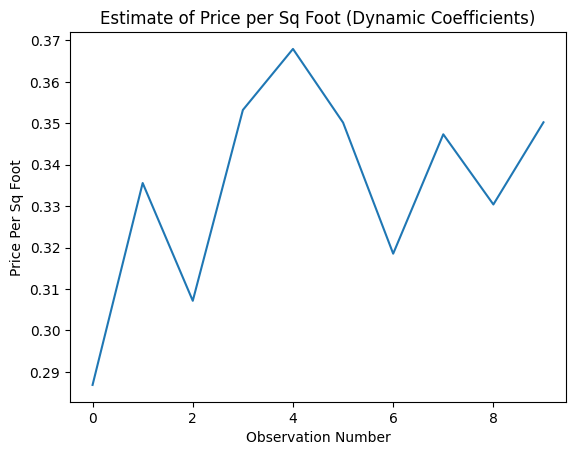

In [9]:
# See the estimated dynamic coefficients
plt.ylabel("Price Per Sq Foot")
plt.xlabel("Observation Number")
plt.title("Estimate of Price per Sq Foot (Dynamic Coefficients)")
plt.plot(np.arange(res2.smoothed_state.shape[1]), res2.smoothed_state[0]);
plt.show()

## Testing the dynamic linear model on a more complex dataset

Here we'll borrow a function from the documentation and generate some more complex, fake data to see how well the estimated coefficients compare against a true value:

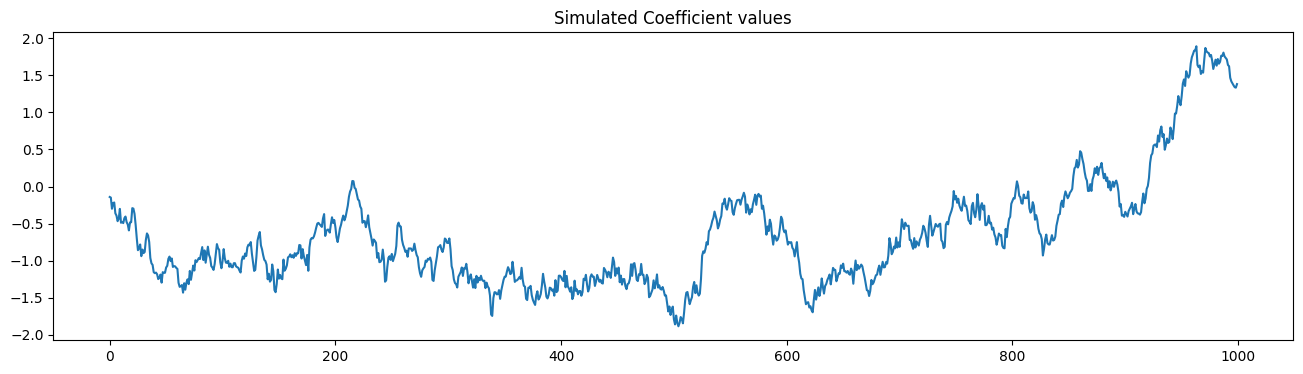

In [10]:
def gen_data_for_model1():
    n = 1000

    np.random.seed(42)
    H = 5
    Q = 0.01

    x_t = np.random.uniform(size=n)
    eps = np.random.normal(scale=H**0.5, size=n)

    # Coefficients evolve over time
    beta_x = np.cumsum(np.random.normal(size=n, scale=Q**0.5))

    y_t = beta_x * x_t + eps
    return y_t, x_t, beta_x


y_t, x_t, beta_x = gen_data_for_model1()
# _ = plt.plot(y_t)
fig, axes = plt.subplots(1, figsize=(16, 4))
plt.title("Simulated Coefficient values")
plt.plot(beta_x);

Next let's re-use our custom `MLEModel` and see how well this estimates the dynamic coefficients:

In [11]:
# fit the model again
mod3 = DynamicLinearRegression(y_t, x_t)
res3 = mod3.fit()

print(res3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30692D+00    |proj g|=  2.33478D-01

At iterate    5    f=  2.22110D+00    |proj g|=  5.50112D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     17      1     0     0   7.523D-08   2.220D+00
  F =   2.2197324322464138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                              Statespace Model Results                             
Dep. Variable:                           y   No.

 This problem is unconstrained.


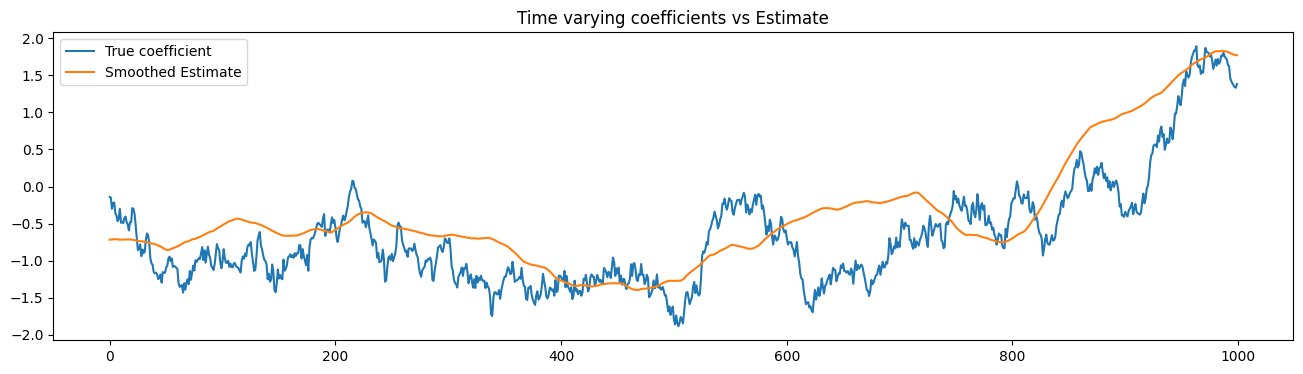

In [12]:
fig, axes = plt.subplots(1, figsize=(16, 4))
plt.plot(beta_x, label='True coefficient')
plt.plot(res3.smoothed_state[0], label='Smoothed Estimate')
plt.title("Time varying coefficients vs Estimate")
plt.legend();

We see that we got very close with $H$ and $Q$ and a fair estiamte of the underlying coefficients.

## References

Suggested next steps are to explore the `statsmodels` [documentation on Custom statespace models](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_custom_models.html) for more detailed and more complex examples.

1. [Custom statespace models](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_custom_models.html)
2. [State space modeling: Local Linear Trends](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html)